In [49]:
import string
import psycopg2
from nltk.tokenize import word_tokenize
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures
from nltk.corpus import stopwords
import plotly.graph_objects as go
import networkx as nx

In [4]:
params = {
    "host": "localhost",
    "port": 5432,
    "database": "Medhelp",
    "user": "postgres",
    "password": "qwe123!@#",
}
conn = psycopg2.connect(**params)
cur = conn.cursor()

In [5]:
    sql_fetch_data = """
        SELECT
            Q.subj_msg, string_agg(P.post_msg, ',,, ' ORDER BY Q.created_timestamp DESC)
        FROM 
            question AS Q
        JOIN 
            post AS P ON (Q.subj_id = P.subj_id)
        WHERE
            Q.answer_count >= 10
            AND P.type = 'Answer'
        GROUP BY
            Q.subj_msg
    """
    cur.execute(sql_fetch_data)
    raw_data = cur.fetchall()

In [7]:
corpus = ""
for idx, conv in enumerate(raw_data):
    corpus += conv[0] + '\n'
    for answer in conv[1].split(",,, "):
        corpus += answer + '\n'
corpus

'Has anyone experienced blood pressure of over 280 close to 300? Could you please share what you were feeling at the time, all your symptoms etc. It would be so helpful to get insight..thank you!\nMy blood pressure was at 280 when the medics came to take me to the emergency room.\xa0\xa0I became nauseous, experienced chest pains that felt like pressure on my chest and upper arms, and felt like I needed to lie down.\xa0\xa0Although I functioned, I later remembered little of anything.\xa0\xa0I don\'t remember my blood pressure being taken or the ambulance ride to the doctor.\xa0\xa0My blood pressure was down to 220 before I started remembering anything.\xa0\xa0The doctors said that I didn\'t have a heart attack, but until the catheterization, they thought that I had because of the enzyme troponin that my heart produced.\xa0\xa0Hope this helps\nI am sharing to some of the symptoms of if you have an over 280 close to 300 the high blood pressure: a Severe headache, Fatigue or confusion, Vis

In [47]:
# find collocations for each word
def get_collocations(corpus, windowsize=10, numresults=10):
    '''This function uses the Natural Language Toolkit to find the top collocations in a corpus.
    It takes as an argument a string that contains the corpus you want to
    find collocations from. It prints the top collocations it finds.
    '''
    # convert the corpus (a string) into  a list of words
    tokens = word_tokenize(corpus)
    # initialize the bigram association measures object to score each collocation
    bigram_measures = BigramAssocMeasures()
    # initialize the bigram collocation finder object to find and rank collocations
    finder = BigramCollocationFinder.from_words(tokens, window_size=windowsize)
    # apply a series of filters to narrow down the collocation results
    ignored_words = stopwords.words('english')
    ignored_words.extend(["im", "let", "go", "dr"])
    finder.apply_word_filter(lambda w: len(w) < 2 or w.lower() in ignored_words)
    finder.apply_freq_filter(2)
    # calculate the top results by T-score
    # list of all possible measures: .raw_freq, .pmi, .likelihood_ratio, .chi_sq, .phi_sq, .fisher, .student_t, .mi_like, .poisson_stirling, .jaccard, .dice
    results = finder.nbest(bigram_measures.student_t, numresults)
    # print the results
    print("Top ", str(numresults), " collocations:")
    for k, v in results:
        print(str(k), ", ", str(v))
    return results

In [45]:
def get_keyword_collocations(corpus, keyword, windowsize=10, numresults=10):
    '''This function uses the Natural Language Toolkit to find collocations
    for a specific keyword in a corpus. It takes as an argument a string that
    contains the corpus you want to find collocations from. It prints the top
    collocations it finds for each keyword.
    '''
    # convert the corpus (a string) into  a list of words
    tokens = word_tokenize(corpus)
    # initialize the bigram association measures object to score each collocation
    bigram_measures = BigramAssocMeasures()
    # initialize the bigram collocation finder object to find and rank collocations
    finder = BigramCollocationFinder.from_words(tokens, window_size=windowsize)
    # initialize a function that will narrow down collocates that don't contain the keyword
    keyword_filter = lambda *w: keyword not in w
    # apply a series of filters to narrow down the collocation results
    ignored_words = stopwords.words('english')
    finder.apply_word_filter(lambda w: len(w) < 2 or w.lower() in ignored_words)
    finder.apply_freq_filter(1)
    finder.apply_ngram_filter(keyword_filter)
    # calculate the top results by T-score
    # list of all possible measures: .raw_freq, .pmi, .likelihood_ratio, .chi_sq, .phi_sq, .fisher, .student_t, .mi_like, .poisson_stirling, .jaccard, .dice
    results = finder.nbest(bigram_measures.student_t, numresults)
    # print the results
    print("Top collocations for ", str(keyword), ":")
    print(results)
    collocations = ''
    for k, v in results:
        if k != keyword:
            collocations += k + ' '
        else:
            collocations += v + ' '
    print(collocations, '\n')
    return results

In [62]:
# Clean the data
translator = str.maketrans('', '', string.punctuation)
data = corpus.translate(translator)  # remove punctuation
data = "".join(i for i in data if ord(i) < 128)  # remove non-ascii characters

# Get the top collocations for the entire corpus
top_collocations = get_collocations(data, 30, 90)
print(' ')

# Replace this with a list of keywords you want to find collocations for
words_of_interest = ["blood", "pressure"]

collocations = dict()
# Get the top collocations for each keyword in the list above
for word in words_of_interest:
    result = get_keyword_collocations(data, word, 30, 60)
    collocations[word] = [token for coll in result for token in coll if token != word]
    
print(collocations)

Top  90  collocations:
blood ,  pressure
systolic ,  number
number ,  number
cortisol ,  cortisol
heart ,  rate
cortisol ,  levels
done ,  day
weight ,  loss
heart ,  attack
nerves ,  nerves
anyone ,  done
diastolic ,  number
weight ,  lbs
done ,  fast
start ,  fast
nerves ,  receptors
levels ,  elevated
test ,  cortisol
water ,  fast
number ,  systolic
100mg ,  NAME
25 ,  NAME
17080 ,  high
25 ,  100mg
50 ,  NAME
mum ,  miss
cortisol ,  elevated
elevated ,  cortisol
50 ,  100mg
Ubiquinol ,  garlic
25 ,  50
weight ,  start
garlic ,  Vitamin
day ,  fast
cortisol ,  test
number ,  130
high ,  blood
week ,  ago
systolic ,  diastolic
number ,  diastolic
top ,  number
fast ,  start
dosage ,  100mg
dosage ,  25
dosage ,  50
garlic ,  supplement
bp ,  290
neurotransmitters ,  nerves
research ,  anyone
hormone ,  adrenal
needing ,  know
increased ,  cortisol
Regards ,  Gord
test ,  blood
pressure ,  medication
research ,  done
garlic ,  tablets
old ,  male
number ,  80
weight ,  182103
year , 

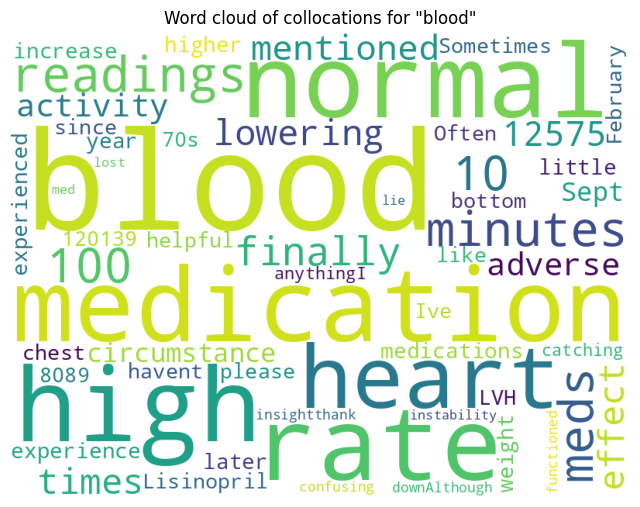

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Prepare word weights (all equal in this case)
word_weights = {word: 1 for word in collocations["pressure"]}

# Create the word cloud
wordcloud = WordCloud(background_color='white', width=800, height=600).generate_from_frequencies(word_weights)

# Create the plot
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word cloud of collocations for "blood"')
plt.show()

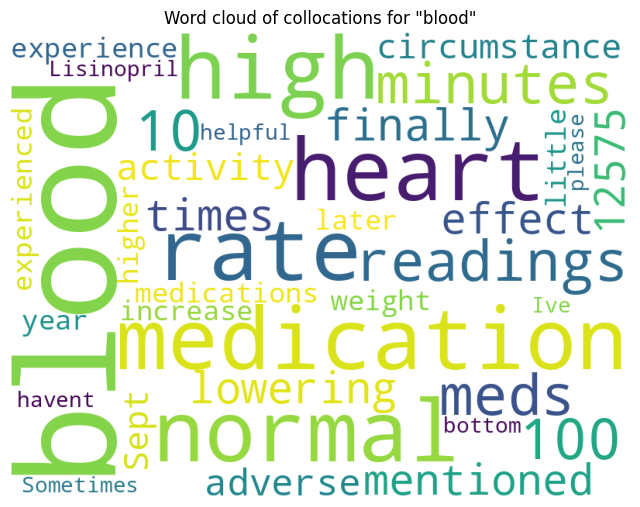

In [31]:
from wordcloud import WordCloud

# Prepare word weights (all equal in this case)
word_weights = {word: 1 for word in collocations["pressure"]}

# Create the word cloud
wordcloud = WordCloud(background_color='white', width=800, height=600).generate_from_frequencies(word_weights)

# Create the plot
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word cloud of collocations for "blood"')
plt.show()

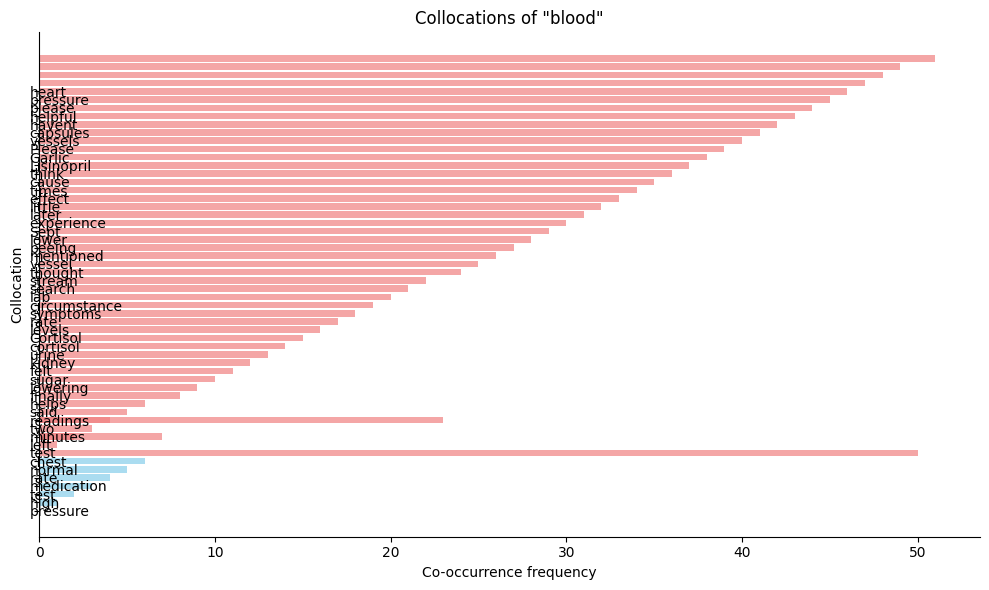

In [37]:
import matplotlib.pyplot as plt

# Define the list of 40 collocations
blood_collocations = collocations["blood"]

# Define the word of interest
word_of_interest = "blood"

# Split the collocations into two lists based on their relative position to the word of interest
collocations_left = [c for c in blood_collocations if c.lower() < word_of_interest.lower()]
collocations_right = [c for c in blood_collocations if c.lower() > word_of_interest.lower()]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the left collocations
ax.barh(collocations_left[::-1], range(len(collocations_left)), color='skyblue', alpha=0.7)
ax.set_yticks(range(len(collocations_left)))
ax.set_yticklabels(collocations_left[::-1], ha='right')

# Plot the right collocations
ax.barh(collocations_right, range(len(collocations_right)), color='lightcoral', alpha=0.7)
ax.set_yticks(range(len(collocations_right)))
ax.set_yticklabels(collocations_right, ha='left')

# Add a vertical line to divide the plot
ax.axvline(0, color='black', linestyle='--', linewidth=0.5)

# Set labels and title
ax.set_xlabel('Co-occurrence frequency')
ax.set_ylabel('Collocation')
ax.set_title('Collocations of "blood"')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Build a network from scratch

In [63]:
node_list = {token for coll in top_collocations for token in coll}

G = nx.Graph()

for i in node_list:
    G.add_node(i)

for coll in top_collocations:
    G.add_edges_from([(coll[0], coll[1])])

pos = nx.spring_layout(G, k=0.5, iterations=100) 

for n, p in pos.items():
    G.nodes[n]['pos'] = p

### G (nodes and edges) -> plotly object (go)

In [64]:
# Edges:
edge_ = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_['x'] += tuple([x0, x1, None])
    edge_['y'] += tuple([y0, y1, None])

In [65]:
# Nodes:
node_ = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='pinkyl',
        reversescale=True,
        color=[],
        size=37,
        colorbar=dict(
            thickness=1,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_['x'] += tuple([x])
    node_['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_['marker']['color'] += tuple([len(adjacencies[1])])
    info = adjacencies[0]
    node_['text'] += tuple([info])

### Show the graph

In [81]:
fig = go.Figure(data=[edge_, node_],
            layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=21, l=5, r=5, t=40),
                annotations=[dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper")],
                xaxis=dict(showgrid=False, 
                           zeroline=False,
                           showticklabels=False, 
                           mirror=True),
                yaxis=dict(showgrid=False, 
                           zeroline=False,
                           showticklabels=False, 
                           mirror=True),
                font=dict(size=8, family="Arial")
                )
            )
fig.show()